# SDK installation

In [1]:
# ! python -m ipykernel install --user \
#         --name clika \
#         --display-name "conda_env"

In [2]:
# check venv
import sys
print(sys.executable)

/home/bar/miniconda3/envs/clika/bin/python


In [3]:
# make sure python version >= 3.8
! python3 --version
! pwd

Python 3.8.16
/home/bar/projects/clika_compression_examples_internal/tutorial_notebooks


In [4]:
# https://docs.clika.io/docs/next/installation/index.html

# Install dependencies

In [5]:
! pip list | grep clika-compression

clika-compression             0.1.0


In [6]:
! pip3 install --upgrade pip
! pip install torch==2.0.1 torchmetrics==1.0.1 torchvision==0.15.2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
from typing import Callable, Union, Dict
import argparse
from functools import partial
import warnings
from pathlib import Path

In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import torchmetrics

# Model source code

### Define base model

In [10]:
class BasicMNIST(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=(2, 2), stride=None, padding=(0, 0), dilation=(1, 1))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [11]:
model = BasicMNIST()

### Define loss function

In [12]:
def compute_loss_fn(pred, target):
    loss = F.nll_loss(
        F.log_softmax(pred, dim=1),
        target
    )

    return loss

### Define optimizer

In [13]:
INITIAL_LR = 0.1

optimizer = torch.optim.Adadelta(params=model.parameters(), lr=INITIAL_LR)

### Define train/eval dataloaders

In [14]:
def get_loader(data_dir, batch_size, num_workers=0, train=True):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = torchvision.datasets.MNIST(root=data_dir,
                                         train=train,
                                         transform=transform,
                                         target_transform=None,
                                         download=True)
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              num_workers=num_workers,
                                              pin_memory=True,
                                              shuffle=True)
    return data_loader

### Define metric

In [15]:
class MultiClassAccuracy(torchmetrics.classification.accuracy.MulticlassAccuracy):

    def update(self, preds: torch.Tensor, target: torch.Tensor) -> None:
        return super().update(preds, target)

    def compute(self) -> torch.Tensor:
        results = super().compute()
        return results * 100.0

In [16]:
NUM_CLASSES = 10

In [17]:
metric_fn = MultiClassAccuracy(num_classes=NUM_CLASSES)

### Wrap Loss, DataLoaders, Metrics for CLIKA SDK

In [18]:
# Loss
train_losses = {"NLL_loss": compute_loss_fn}
eval_losses = {"NLL_loss": compute_loss_fn}

# DataLoaders
DATA_DIR = "."
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 16
WORKERS = 0
get_train_loader = partial(get_loader, DATA_DIR, TRAIN_BATCH_SIZE, WORKERS, True)
get_eval_loader = partial(get_loader, DATA_DIR, EVAL_BATCH_SIZE, WORKERS, False)

# Metrics
train_metrics = {"acc": metric_fn}
eval_metrics = {"acc": metric_fn}

# Train model with PyTorch

In [19]:
TRAIN_EPOCH = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_criterion = train_losses["NLL_loss"]
eval_criterion = eval_losses["NLL_loss"]
eval_acc = eval_metrics["acc"]
eval_acc.to(device)

for epoch in range(1, TRAIN_EPOCH + 1):
    model.train()
    train_loader = get_train_loader()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = train_criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                  ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    model.eval()
    eval_loader = get_eval_loader()
    loss_list = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(eval_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            eval_loss = eval_criterion(output, target)
            loss_list.append(eval_loss.item())

            eval_acc.update(output, target)
    accuracy = eval_acc.compute()
    avg_loss = sum(loss_list) / len(loss_list)
    print(f"\nAccuracy: {accuracy:.3f}, AvgLoss: {avg_loss:.3f}\n")

print("PyTorch training done!!")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 18571189.19it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 4954830.41it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5200606.54it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 16551284.77it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train Epoch: 1 [0/60000                   (0%)]	Loss: 2.312673
Train Epoch: 1 [3200/60000                   (5%)]	Loss: 0.649512
Train Epoch: 1 [6400/60000                   (11%)]	Loss: 0.445746
Train Epoch: 1 [9600/60000                   (16%)]	Loss: 0.416967
Train Epoch: 1 [12800/60000                   (21%)]	Loss: 0.373801
Train Epoch: 1 [16000/60000                   (27%)]	Loss: 0.305178
Train Epoch: 1 [19200/60000                   (32%)]	Loss: 0.298416
Train Epoch: 1 [22400/60000                   (37%)]	Loss: 0.175979
Train Epoch: 1 [25600/60000                   (43%)]	Loss: 0.123523
Train Epoch: 1 [28800/60000                   (48%)]	Loss: 0.260732
Train Epoch: 1 [32000/60000                   (53%)]	Loss: 0.351966
Train Epoch: 1 [35200/60000                   (59%)]	Loss: 0.088848
Train Epoch: 1 [38400/60000                   (64%)]	Loss: 0.312028
Train Epoch: 1 [41600/60000                   (69%)]	Loss: 0

In [20]:
_trained_ckpt = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict()
}
model


BasicMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
_trained_ckpt = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict()
}
torch.save(_trained_ckpt, "pytorch_fp32_model.pt")

now our `model` and `optimizer` contain latest checkpoint

# Start QAT from the checkpoint

In [22]:
from clika_compression import PyTorchCompressionEngine, \
    QATQuantizationSettings, \
    DeploymentSettings_TensorRT_ONNX, \
    LayerQuantizationSettings

from clika_compression.settings import (
    generate_default_settings, ModelCompileSettings
)

In [23]:
# Alternatively, you can run QAT from scratch using the flag "is_training_from_scratch" in "PyTorchCompressionEngine.optimize"
# although it will take slgithly longer.

state_dict = torch.load("pytorch_fp32_model.pt", map_location=None)

model.load_state_dict(state_dict["model"])
optimizer.load_state_dict(state_dict["optimizer"])

## 0. Configure QAT settings

In [24]:
settings = generate_default_settings()

In [25]:
# We are applying QAT comprresion method
settings.global_quantization_settings = QATQuantizationSettings()

## 1. Deployment Setting
Let's deploy our model to TensorRT!

TensorRT is a high performance inference engine that can speed up your AI models on Nvidia GPUs.

In [26]:
deployment_setting = DeploymentSettings_TensorRT_ONNX(
    graph_author="CLIKA",
    graph_description=None,
    input_shapes_for_deployment=[(None, 1, 28, 28)]
)

settings.deployment_settings = deployment_setting

## 2. Apply 8 bit quantization on both Weight and Activation tensors.

In [27]:
settings.global_quantization_settings.weights_num_bits = 8
settings.global_quantization_settings.activations_num_bits = 8

## 3. Configure training hyper-parameters

In [28]:
settings.training_settings.num_epochs = 5

# if set limit the number of steps per epoch
settings.training_settings.steps_per_epoch = None
settings.training_settings.evaluation_steps = None
settings.training_settings.lr_warmup_epochs = 0
settings.training_settings.lr_warmup_steps_per_epoch = 0

# number of steps to collect statistics for initial compression
settings.training_settings.stats_steps = 50

# number of steps for averaging losses and accuracies
settings.training_settings.print_num_steps_averaging = 20

# etc
settings.training_settings.print_interval = 50
settings.training_settings.save_interval = 1
settings.training_settings.reset_training_dataset_between_epochs = False
settings.training_settings.reset_evaluation_dataset_between_epochs = False
settings.training_settings.mixed_precision = True
settings.training_settings.use_fp16_weights = False
settings.training_settings.use_gradients_checkpoint = False
settings.training_settings.grads_accumulation_steps = 1

## 4. encapsulate model information
- optimizer
- loss
- metric

In [29]:
mcs = ModelCompileSettings(
    optimizer=optimizer,
    training_losses=train_losses,
    training_metrics=train_metrics,
    evaluation_losses=eval_losses,
    evaluation_metrics=eval_metrics
)

## 5. run compression
- model
- train dataloader
- eval dataloader

In [30]:
OUTPUT_DIR = "./outputs"

In [31]:
engine = PyTorchCompressionEngine()

final = engine.optimize(
    output_path=OUTPUT_DIR,
    settings=settings,
    model=model,
    model_compile_settings=mcs,
    init_training_dataset_fn=get_train_loader,
    init_evaluation_dataset_fn=get_eval_loader,
    is_training_from_scratch=False,
)

== License is Valid. Time Left: 364 days 1 hour 3 minutes left ==
[2023-08-08 18:30:15] Version: 0.1.0
Created log at: outputs/logs/clika_optimize_2023-08-08_18:30:15.530841.log
[2023-08-08 18:30:15] Initializing output directory at: 'outputs/logs'
[2023-08-08 18:30:15] Starting Single-GPU optimization
[2023-08-08 18:30:15] 
Training Settings:
	+                              num_epochs = 5
	+                         steps_per_epoch = 1875
	+                        evaluation_steps = -1
	+                             stats_steps = 50
	+   reset_training_dataset_between_epochs = False
	+ reset_evaluation_dataset_between_epochs = False
	+                          print_interval = 50
	+               print_num_steps_averaging = 20
	+                           save_interval = 1
	+                     use_mixed_precision = True
	+                        use_fp16_weights = False
	+                use_gradients_checkpoint = False
	+                grads_accumulation_steps = 1
	+               

[2023-08-08 18:30:24] Epoch 1 	[ 650/1875]	eta: 0:00:09	loss - 0.0331 (0.0243) | NLL_loss - 0.0331 (0.0243)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20045MiB	vmem: 146MB
[2023-08-08 18:30:24] Epoch 1 	[ 700/1875]	eta: 0:00:09	loss - 0.1860 (0.0340) | NLL_loss - 0.1860 (0.0340)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20047MiB	vmem: 146MB
[2023-08-08 18:30:25] Epoch 1 	[ 750/1875]	eta: 0:00:08	loss - 0.1191 (0.0554) | NLL_loss - 0.1191 (0.0554)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20047MiB	vmem: 146MB
[2023-08-08 18:30:25] Epoch 1 	[ 800/1875]	eta: 0:00:08	loss - 0.0373 (0.0277) | NLL_loss - 0.0373 (0.0277)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20047MiB	vmem: 146MB
[2023-08-08 18:30:26] Epoch 1 	[ 850/1875]	eta: 0:00:08	loss - 0.0791 (0.0378) | NLL_loss - 0.0791 (0.0378)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20048MiB	vmem: 146MB
[2023-08-08 18:30:26] Epoch 1 	[ 900/1875]	eta: 0:00:07	loss - 0.0148 (0.0581) | NLL_loss - 0.0148 (0.0581)	iter-time: 0.009s	data

[2023-08-08 18:30:36] Time elapsed: 0:00:17
[2023-08-08 18:30:36] Time left: 0:01:09 (4 epochs left)
[2023-08-08 18:30:36] Saved checkpoint at: 'outputs/epoch_1/model.pompom'
[2023-08-08 18:30:36] Starting Epoch 2
[2023-08-08 18:30:37] Epoch 2 	[  50/1875]	eta: 0:00:15	loss - 0.0017 (0.0191) | NLL_loss - 0.0017 (0.0191)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20062MiB	vmem: 146MB
[2023-08-08 18:30:37] Epoch 2 	[ 100/1875]	eta: 0:00:15	loss - 0.0282 (0.0586) | NLL_loss - 0.0282 (0.0586)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20062MiB	vmem: 146MB
[2023-08-08 18:30:38] Epoch 2 	[ 150/1875]	eta: 0:00:14	loss - 0.0072 (0.0244) | NLL_loss - 0.0072 (0.0244)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20062MiB	vmem: 146MB
[2023-08-08 18:30:38] Epoch 2 	[ 200/1875]	eta: 0:00:14	loss - 0.1205 (0.0228) | NLL_loss - 0.1205 (0.0228)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20062MiB	vmem: 146MB
[2023-08-08 18:30:39] Epoch 2 	[ 250/1875]	eta: 0:00:14	loss - 0.0003 (0.0286) | NLL_loss 

[2023-08-08 18:30:54] Epoch 2 - Evaluating 	[300/625]	eta: 0:00:00	eval_loss - 0.0020 (0.0811) | eval_NLL_loss - 0.0020 (0.0811)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20024MiB	vmem: 146MB
[2023-08-08 18:30:54] Epoch 2 - Evaluating 	[350/625]	eta: 0:00:00	eval_loss - 0.0015 (0.0256) | eval_NLL_loss - 0.0015 (0.0256)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20024MiB	vmem: 146MB
[2023-08-08 18:30:54] Epoch 2 - Evaluating 	[400/625]	eta: 0:00:00	eval_loss - 0.0005 (0.0178) | eval_NLL_loss - 0.0005 (0.0178)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20024MiB	vmem: 146MB
[2023-08-08 18:30:54] Epoch 2 - Evaluating 	[450/625]	eta: 0:00:00	eval_loss - 0.0001 (0.0073) | eval_NLL_loss - 0.0001 (0.0073)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20024MiB	vmem: 146MB
[2023-08-08 18:30:54] Epoch 2 - Evaluating 	[500/625]	eta: 0:00:00	eval_loss - 0.0023 (0.0482) | eval_NLL_loss - 0.0023 (0.0482)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20024MiB	vmem: 146MB
[2023-08-08 18:30:54] Epo

[2023-08-08 18:31:05] Epoch 3 	[1300/1875]	eta: 0:00:04	loss - 0.0050 (0.0123) | NLL_loss - 0.0050 (0.0123)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20134MiB	vmem: 146MB
[2023-08-08 18:31:06] Epoch 3 	[1350/1875]	eta: 0:00:04	loss - 0.0015 (0.0212) | NLL_loss - 0.0015 (0.0212)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20154MiB	vmem: 146MB
[2023-08-08 18:31:06] Epoch 3 	[1400/1875]	eta: 0:00:03	loss - 0.1520 (0.0300) | NLL_loss - 0.1520 (0.0300)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20154MiB	vmem: 146MB
[2023-08-08 18:31:06] Epoch 3 	[1450/1875]	eta: 0:00:03	loss - 0.0065 (0.0134) | NLL_loss - 0.0065 (0.0134)	iter-time: 0.008s	data-time: 0.002s	sys-mem: 20155MiB	vmem: 146MB
[2023-08-08 18:31:07] Epoch 3 	[1500/1875]	eta: 0:00:03	loss - 0.0001 (0.0085) | NLL_loss - 0.0001 (0.0085)	iter-time: 0.007s	data-time: 0.002s	sys-mem: 20154MiB	vmem: 146MB
[2023-08-08 18:31:07] Epoch 3 	[1550/1875]	eta: 0:00:02	loss - 0.0043 (0.0082) | NLL_loss - 0.0043 (0.0082)	iter-time: 0.007s	data

[2023-08-08 18:31:14] Epoch 4 	[ 350/1875]	eta: 0:00:11	loss - 0.0030 (0.0280) | NLL_loss - 0.0030 (0.0280)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20117MiB	vmem: 146MB
[2023-08-08 18:31:15] Epoch 4 	[ 400/1875]	eta: 0:00:11	loss - 0.0148 (0.0172) | NLL_loss - 0.0148 (0.0172)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20117MiB	vmem: 146MB
[2023-08-08 18:31:15] Epoch 4 	[ 450/1875]	eta: 0:00:11	loss - 0.0047 (0.0150) | NLL_loss - 0.0047 (0.0150)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20117MiB	vmem: 146MB
[2023-08-08 18:31:15] Epoch 4 	[ 500/1875]	eta: 0:00:10	loss - 0.0189 (0.0167) | NLL_loss - 0.0189 (0.0167)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20117MiB	vmem: 146MB
[2023-08-08 18:31:16] Epoch 4 	[ 550/1875]	eta: 0:00:10	loss - 0.0104 (0.0057) | NLL_loss - 0.0104 (0.0057)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20129MiB	vmem: 146MB
[2023-08-08 18:31:16] Epoch 4 	[ 600/1875]	eta: 0:00:10	loss - 0.0011 (0.0109) | NLL_loss - 0.0011 (0.0109)	iter-time: 0.009s	data

[2023-08-08 18:31:30] Epoch 4 - Evaluating 	[625/625]	eta: 0:00:00	eval_loss - 0.0015 (0.0288) | eval_NLL_loss - 0.0015 (0.0288)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20120MiB	vmem: 146MB
[2023-08-08 18:31:30] Epoch 4 - Evaluating Total time: 0:00:01
[2023-08-08 18:31:30] Summary of Epoch 4
Evaluation
├── eval_NLL_loss = 0.02884
│   ├── Lowest so far = 0.01542 (Epoch: 1)
│   ├── Highest so far = 0.05037 (Epoch: 3)
│   ├── Original value = 0.04669
│   │   └── Difference = ↘ -0.01785,-38.239%
│   └── Previous epoch value = 0.05037 (Epoch 3)
│       └── Difference = ↘ -0.02153,-42.744%
├── eval_acc = 99.00522
│   ├── Lowest so far = 98.8696 (Epoch: 3)
│   ├── Highest so far = 99.00522 (Epoch: 4)
│   ├── Original value = 98.75021
│   │   └── Difference = ↗ +0.25501,+0.258%
│   └── Previous epoch value = 98.8696 (Epoch 3)
│       └── Difference = ↗ +0.13562,+0.137%
└── eval_loss = 0.02884
    ├── Lowest so far = 0.01542 (Epoch: 1)
    ├── Highest so far = 0.05037 (Epoch: 3)
    ├── O

[2023-08-08 18:31:45] Epoch 5 	[1700/1875]	eta: 0:00:01	loss - 0.0005 (0.0036) | NLL_loss - 0.0005 (0.0036)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20132MiB	vmem: 146MB
[2023-08-08 18:31:45] Epoch 5 	[1750/1875]	eta: 0:00:01	loss - 0.0002 (0.0072) | NLL_loss - 0.0002 (0.0072)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20132MiB	vmem: 146MB
[2023-08-08 18:31:46] Epoch 5 	[1800/1875]	eta: 0:00:00	loss - 0.1130 (0.0131) | NLL_loss - 0.1130 (0.0131)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20132MiB	vmem: 146MB
[2023-08-08 18:31:46] Epoch 5 	[1850/1875]	eta: 0:00:00	loss - 0.0001 (0.0075) | NLL_loss - 0.0001 (0.0075)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20133MiB	vmem: 146MB
[2023-08-08 18:31:46] Epoch 5 	[1875/1875]	eta: 0:00:00	loss - 0.0000 (0.0137) | NLL_loss - 0.0000 (0.0137)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20133MiB	vmem: 146MB
[2023-08-08 18:31:46] Epoch 5 Total time: 0:00:15
[2023-08-08 18:31:46] Epoch 5 - Evaluating 	[ 50/625]	eta: 0:00:01	eval_loss - 0

## 6. deploy model
`PyTorchCompressionEngine.deploy(..)` will export your model in [QDQ ONNX format](https://onnxruntime.ai/docs/performance/model-optimizations/quantization.html#onnx-quantization-representation-format)

exported onnx can be compiled on TensorRT SDK for its best performance to NVIDIA GPUs.

see [this page](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#convert-model) for more details about parsing ONNX to TensorRT

In [32]:
final

'outputs/epoch_5/model.pompom'

In [33]:
engine.deploy(
    clika_state_path=final,
    output_dir_path=OUTPUT_DIR,
    file_suffix=None,
    input_shapes=None,
    graph_author="CLIKA",
    graph_description="Demo - Created by clika.io",
)

[2023-08-08 18:31:49] Version: 0.1.0
[2023-08-08 18:31:49] Deploying Model from: outputs/epoch_5/model.pompom
[2023-08-08 18:31:49] Saved model at: ./outputs/BasicMNIST.onnx


'./outputs/BasicMNIST.onnx'

exported "./outputs/BasicMNIST.onnx" visualized


![](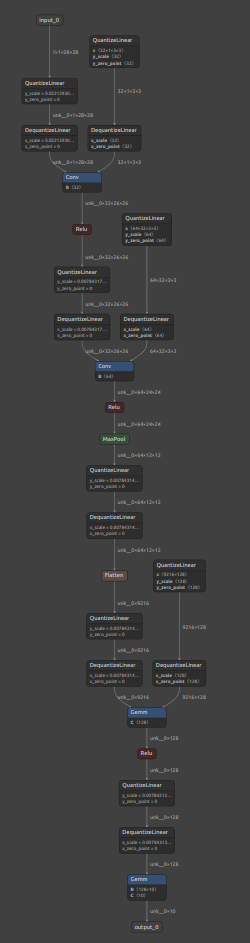
)


Install [tensorrt](https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html#installing) on local machine or use [docker container](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tensorrt) to run the following command

In this example we will use docker image for simplicity.

In [34]:
! docker run --gpus all --rm -v .:/workspace/ nvcr.io/nvidia/tensorrt:23.07-py3 -c trtexec \
        --onnx=outputs/BasicMNIST.onnx \
        --int8 --workspace=1024 \
        --saveEngine=outputs/BasicMNIST.engine \
        --shapes=input_0:16x1x28x28


== NVIDIA TensorRT ==

NVIDIA Release 23.07 (build 63868013)
NVIDIA TensorRT Version 8.6.1
Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Container image Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

https://developer.nvidia.com/tensorrt

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

To install Python sample dependencies, run /opt/tensorrt/python/python_setup.sh

To install the open-source samples corresponding to this TensorRT release version
run /opt/tensorrt/install_opensource.sh.  To build the open source parsers,
plugins, and samples for current top-of-tree on master or a different branch,
run /opt/tensorrt/install

[08/08/2023-09:31:55] [I] [TRT] Loaded engine size: 1 MiB
[08/08/2023-09:31:55] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +1, now: CPU 0, GPU 1 (MiB)
[08/08/2023-09:31:55] [I] Engine deserialized in 0.00270701 sec.
[08/08/2023-09:31:55] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +1, now: CPU 0, GPU 2 (MiB)
[08/08/2023-09:31:55] [I] Setting persistentCacheLimit to 0 bytes.
[08/08/2023-09:31:55] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[08/08/2023-09:31:55] [I] Using random values for input input_0
[08/08/2023-09:31:55] [I] Input binding for input_0 with dimensions 16x1x28x28 is created.
[08/08/2023-09:31:55] [I] Output binding for output_0 with dimensions 16x10

[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0401489 ms - Host latency: 0.0700439 ms (enqueue 0.0184204 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0378906 ms - Host latency: 0.0746704 ms (enqueue 0.0219604 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0419922 ms - Host latency: 0.0715454 ms (enqueue 0.0180664 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.040625 ms - Host latency: 0.0710083 ms (enqueue 0.0182373 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0431152 ms - Host latency: 0.0732422 ms (enqueue 0.0180664 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0339844 ms - Host latency: 0.0680786 ms (enqueue 0.0181641 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0434204 ms - Host latency: 0.072998 ms (enqueue 0.0180542 ms)
[08/08/2023-09:31:58] [I] Average on 10 runs - GPU latency: 0.0421997 ms - Host latency: 0.0714233 ms (enqueue 0.0179077 ms)
[0

## 7. Compare PyTorch, CLIKA deployed performance

In [35]:
# install dependencies to run compiled engine file on python
! pip install tensorrt --extra-index-url https://pypi.ngc.nvidia.com
! git clone https://github.com/NVIDIA-AI-IOT/torch2trt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com, https://pypi.ngc.nvidia.com
Cloning into 'torch2trt'...
remote: Enumerating objects: 4252, done.
remote: Counting objects: 100% (720/720), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 4252 (delta 436), reused 637 (delta 404), pack-reused 3532
Receiving objects: 100% (4252/4252), 7.87 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.


In [36]:
import sys
sys.path.append("torch2trt")

from torch2trt import TRTModule
import tensorrt as trt
trt.__version__

/home/bar/projects/clika_compression_examples_internal/tutorial_notebooks/torch2trt/torch2trt/dataset.py:61: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(self) > 0, 'Cannot create default flattener without input data.')


'8.6.1'

In [37]:
# check model input & output names
import onnx

onnx_graph = onnx.load("./outputs/BasicMNIST.onnx").graph
input_names = [n.name for n in onnx_graph.input]
output_names = [n.name for n in onnx_graph.output]
input_names, output_names

(['input_0'], ['output_0'])

In [38]:
ENGINE_PATH = "./outputs/BasicMNIST.engine"

# read trt engine file
with open(ENGINE_PATH, "rb") as fp:
    engine_bytes = fp.read()
with trt.Logger(trt.Logger.INFO) as logger, trt.Runtime(logger) as runtime:
    engine = runtime.deserialize_cuda_engine(engine_bytes)

# initialize trt_model
trt_model = TRTModule(
    engine=engine,
    input_names=input_names,
    output_names=output_names
)

[08/08/2023-18:32:02] [TRT] [I] Loaded engine size: 1 MiB
[08/08/2023-18:32:02] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +1, now: CPU 0, GPU 1 (MiB)
[08/08/2023-18:32:02] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +1, now: CPU 0, GPU 2 (MiB)
[08/08/2023-18:32:02] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


### ORIGINAL fp32 model (PyTorch)

In [41]:

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

model.cuda()
model.eval()

# warmup
for _ in range(50):
    _ = model(torch.randn(EVAL_BATCH_SIZE, 1, 28, 28).cuda())

eval_loader = get_eval_loader()
_time_list = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(eval_loader):
        data, target = data.to(device), target.to(device)

        starter.record()
        output = model(data)
        ender.record()
        torch.cuda.synchronize()

        _ff_time = starter.elapsed_time(ender)
        _time_list.append(_ff_time)

        eval_acc.update(output, target)

accuracy = eval_acc.compute()
eval_acc.reset()
avg_time = sum(_time_list) / len(_time_list)
print(EVAL_BATCH_SIZE)
print(f"\nAccuracy: {accuracy:.3f}, latency(sec): {avg_time / 1000}\n")

16

Accuracy: 98.750, latency(sec): 0.00013632306926250457



### CLIKA optimized int8 model (TensorRT)

In [42]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

# warmup
for _ in range(50):
    _ = model(torch.randn(EVAL_BATCH_SIZE, 1, 28, 28).cuda())

eval_loader = get_eval_loader()
_time_list = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(eval_loader):
        data, target = data.to(device), target.to(device)

        starter.record()
        output = trt_model(data)
        ender.record()
        torch.cuda.synchronize()

        _ff_time = starter.elapsed_time(ender)
        _time_list.append(_ff_time)

        eval_acc.update(output, target)

accuracy = eval_acc.compute()
eval_acc.reset()
avg_time = sum(_time_list) / len(_time_list)
print(EVAL_BATCH_SIZE)
print(f"\nAccuracy: {accuracy:.3f}, latency(sec): {avg_time / 1000}\n")

16

Accuracy: 99.087, latency(sec): 9.376235609054566e-05



# Resume QAT
Compression process can be resumed from any `.pompom` file.

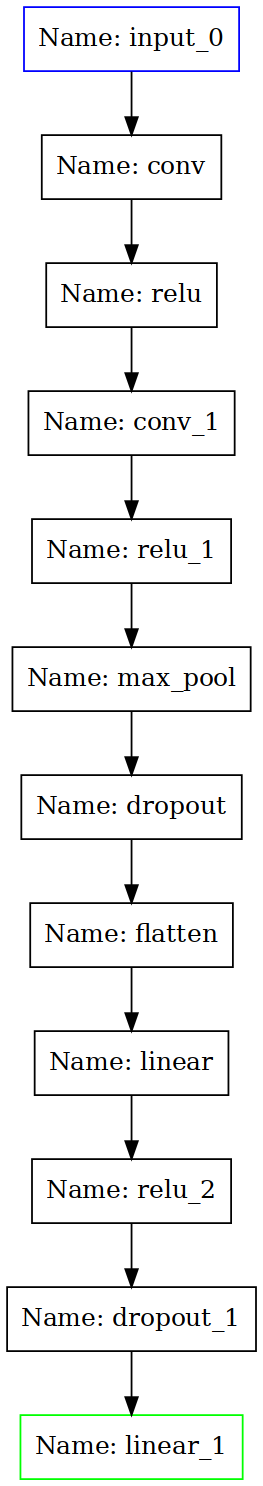

In [43]:
# let's visualize CLIKA SDK extracted model
from IPython.display import Image, display
display(Image(filename="outputs/model_init.png"))

previously we have quantized all layers

let's skip last layer "linear_1" for better accuracy

In [44]:
# skip last layer quantization to maintain higher accuracy
settings.set_quantization_settings_for_layer("linear_1", LayerQuantizationSettings(skip_quantization=True))

In [45]:
engine = PyTorchCompressionEngine()

# skip last layer quantization for better accuracy
last_epoch = settings.training_settings.num_epochs
settings.training_settings.num_epochs = last_epoch + 3  # fine-tune additional 3 epochs

mcs = ModelCompileSettings(
    optimizer=None,
    training_losses=train_losses,
    training_metrics=train_metrics,
    evaluation_losses=eval_losses,
    evaluation_metrics=eval_metrics,
)

In [46]:
final = engine.resume(
    clika_state_path="outputs/epoch_5/model.pompom",
    model_compile_settings=mcs,
    init_training_dataset_fn=get_train_loader,
    init_evaluation_dataset_fn=get_eval_loader,
    settings=settings
)

[2023-08-08 18:32:38] Version: 0.1.0
[2023-08-08 18:32:38] Updating to new Settings
[2023-08-08 18:32:38] 
Training Settings:
	+                              num_epochs = 8
	+                         steps_per_epoch = 1875
	+                        evaluation_steps = -1
	+                             stats_steps = 50
	+   reset_training_dataset_between_epochs = False
	+ reset_evaluation_dataset_between_epochs = False
	+                          print_interval = 50
	+               print_num_steps_averaging = 20
	+                           save_interval = 1
	+                     use_mixed_precision = True
	+                        use_fp16_weights = False
	+                use_gradients_checkpoint = False
	+                grads_accumulation_steps = 1
	+                        lr_warmup_epochs = 0
	+               lr_warmup_steps_per_epoch = 0
	+                             random_seed = 1691499053
	+                 skip_initial_evaluation = False

Global Quantization Settings:
	+ qu

[2023-08-08 18:32:54] Epoch 6 	[1750/1875]	eta: 0:00:01	loss - 0.0260 (0.0132) | NLL_loss - 0.0260 (0.0132)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20190MiB	vmem: 168MB
[2023-08-08 18:32:54] Epoch 6 	[1800/1875]	eta: 0:00:00	loss - 0.0042 (0.0033) | NLL_loss - 0.0042 (0.0033)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20190MiB	vmem: 168MB
[2023-08-08 18:32:55] Epoch 6 	[1850/1875]	eta: 0:00:00	loss - 0.0001 (0.0015) | NLL_loss - 0.0001 (0.0015)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20190MiB	vmem: 168MB
[2023-08-08 18:32:55] Epoch 6 	[1875/1875]	eta: 0:00:00	loss - 0.0041 (0.0027) | NLL_loss - 0.0041 (0.0027)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20183MiB	vmem: 168MB
[2023-08-08 18:32:55] Epoch 6 Total time: 0:00:16
[2023-08-08 18:32:55] Epoch 6 - Evaluating 	[ 50/625]	eta: 0:00:01	eval_loss - 0.0001 (0.0304) | eval_NLL_loss - 0.0001 (0.0304)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20183MiB	vmem: 168MB
[2023-08-08 18:32:56] Epoch 6 - Evaluating 	[100/625]	eta: 

[2023-08-08 18:33:06] Epoch 7 	[1000/1875]	eta: 0:00:07	loss - 0.0020 (0.0118) | NLL_loss - 0.0020 (0.0118)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20203MiB	vmem: 168MB
[2023-08-08 18:33:07] Epoch 7 	[1050/1875]	eta: 0:00:07	loss - 0.0001 (0.0148) | NLL_loss - 0.0001 (0.0148)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20203MiB	vmem: 168MB
[2023-08-08 18:33:07] Epoch 7 	[1100/1875]	eta: 0:00:06	loss - 0.0004 (0.0163) | NLL_loss - 0.0004 (0.0163)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20203MiB	vmem: 168MB
[2023-08-08 18:33:08] Epoch 7 	[1150/1875]	eta: 0:00:06	loss - 0.0009 (0.0042) | NLL_loss - 0.0009 (0.0042)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20203MiB	vmem: 168MB
[2023-08-08 18:33:08] Epoch 7 	[1200/1875]	eta: 0:00:06	loss - 0.0070 (0.0040) | NLL_loss - 0.0070 (0.0040)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20203MiB	vmem: 168MB
[2023-08-08 18:33:09] Epoch 7 	[1250/1875]	eta: 0:00:05	loss - 0.0001 (0.0043) | NLL_loss - 0.0001 (0.0043)	iter-time: 0.009s	data

[2023-08-08 18:33:16] Starting Epoch 8
[2023-08-08 18:33:17] Epoch 8 	[  50/1875]	eta: 0:00:16	loss - 0.0010 (0.0029) | NLL_loss - 0.0010 (0.0029)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20139MiB	vmem: 168MB
[2023-08-08 18:33:17] Epoch 8 	[ 100/1875]	eta: 0:00:16	loss - 0.0000 (0.0053) | NLL_loss - 0.0000 (0.0053)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20140MiB	vmem: 168MB
[2023-08-08 18:33:18] Epoch 8 	[ 150/1875]	eta: 0:00:15	loss - 0.0133 (0.0058) | NLL_loss - 0.0133 (0.0058)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20140MiB	vmem: 168MB
[2023-08-08 18:33:18] Epoch 8 	[ 200/1875]	eta: 0:00:15	loss - 0.0023 (0.0044) | NLL_loss - 0.0023 (0.0044)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20140MiB	vmem: 168MB
[2023-08-08 18:33:19] Epoch 8 	[ 250/1875]	eta: 0:00:14	loss - 0.0001 (0.0029) | NLL_loss - 0.0001 (0.0029)	iter-time: 0.009s	data-time: 0.002s	sys-mem: 20142MiB	vmem: 168MB
[2023-08-08 18:33:19] Epoch 8 	[ 300/1875]	eta: 0:00:14	loss - 0.0329 (0.0062) | NLL_loss -

[2023-08-08 18:33:34] Epoch 8 - Evaluating 	[350/625]	eta: 0:00:00	eval_loss - 0.0147 (0.0129) | eval_NLL_loss - 0.0147 (0.0129)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20156MiB	vmem: 168MB
[2023-08-08 18:33:34] Epoch 8 - Evaluating 	[400/625]	eta: 0:00:00	eval_loss - 0.0000 (0.0388) | eval_NLL_loss - 0.0000 (0.0388)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20156MiB	vmem: 168MB
[2023-08-08 18:33:35] Epoch 8 - Evaluating 	[450/625]	eta: 0:00:00	eval_loss - 0.0068 (0.0348) | eval_NLL_loss - 0.0068 (0.0348)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20156MiB	vmem: 168MB
[2023-08-08 18:33:35] Epoch 8 - Evaluating 	[500/625]	eta: 0:00:00	eval_loss - 0.3008 (0.0351) | eval_NLL_loss - 0.3008 (0.0351)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20156MiB	vmem: 168MB
[2023-08-08 18:33:35] Epoch 8 - Evaluating 	[550/625]	eta: 0:00:00	eval_loss - 0.0009 (0.0379) | eval_NLL_loss - 0.0009 (0.0379)	iter-time: 0.003s	data-time: 0.001s	sys-mem: 20156MiB	vmem: 168MB
[2023-08-08 18:33:35] Epo